# Altın Fiyat Tahmini | LSTM Time Series

2001–2019 yılları arasındaki günlük altın fiyatı verilerini kullanarak **USD PM** değerini tahmin eden LSTM derin öğrenme modeli. Sliding Window yöntemiyle zaman serisi sekansları oluşturulmaktadır.

| Özellik | Detay |
|---------|-------|
| **Veri Seti** | gold_price.csv — 4.682 günlük kayıt (2001–2019, NA temizleme sonrası) |
| **Problem Türü** | Zaman Serisi Tahmini (Regresyon) |
| **Hedef Değişken** | `USD (PM)` (gün sonu altın fiyatı, USD/ons) |
| **Model** | 2-katmanlı LSTM (50+50 birim) + Dropout — Window Size: 30 gün |
| **Ön İşleme** | MinMaxScaler → Sliding Window Sekansları |
| **Best val_loss** | 1.897e-04 (MSE, normalize) |

**İş Akışı:** Veri Yükleme → EDA → Ölçekleme → Sliding Window → LSTM Eğitimi → EarlyStopping → MAE/RMSE → Kayıt



## 0. Proje Hakkında

### Problemin Tanımı
Bu proje, geçmiş altın fiyat verilerini kullanarak gelecekteki altın fiyatlarını (**USD PM**) tahmin etmeyi amaçlar. Altın fiyatları ekonomik istikrarsızlık ve enflasyon gibi birçok faktörden etkilenen karmaşık bir zaman serisidir.

### Hedef Değişken
**USD (PM)**: Gün sonu altın fiyatı (Amerikan Doları cinsinden).

### Veri Seti Özeti
Veri seti 2001-2019 yılları arasındaki günlük altın fiyatlarını (USD, GBP, EURO) içermektedir.

### Varsayımlar ve Kısıtlar
- Hafta sonları ve tatil günlerinde fiyat verisi olmayabilir.
- Fiyatlar arasındaki zaman bağımlılığı LSTM ile modellenecektir.


## 1. Veri Yükleme (Data Loading)
Gerekli kütüphaneleri yüklüyor ve CSV dosyasını okuyoruz.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings('ignore')

# Veri Yükleme
file_path = 'gold_price.csv'
df = pd.read_csv(file_path)

print("Veri seti boyutu:", df.shape)
df.head()


C:\Users\Erhan\anaconda3\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


Veri seti boyutu: (4718, 7)


,Date,USD (AM),USD (PM),GBP (AM),GBP (PM),EURO (AM),EURO (PM)
0,2001-01-02,272.80,271.10,183.026,181.617,288.677,287.334
1,2001-01-03,269.00,267.15,178.916,177.390,281.823,281.655
2,2001-01-04,268.75,267.10,178.869,178.352,282.538,282.049
3,2001-01-05,268.00,267.40,178.488,178.148,280.775,280.882
4,2001-01-08,268.60,268.30,178.769,178.664,282.410,282.481


## 2. Veri Setinin Yapısal İncelemesi
Tarih sütununu düzenleme ve eksik veri kontrolü.

In [5]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

print('Eksik Değerler:', df.isnull().sum())

# Sadece USD (PM) üzerine odaklanacağız
df = df[['USD (PM)']]
df.dropna(inplace=True)
print('Temizlenmiş Veri Boyutu:', df.shape)


Eksik Değerler: USD (AM)      0
USD (PM)     36
GBP (AM)      0
GBP (PM)     36
EURO (AM)     0
EURO (PM)    36
dtype: int64
Temizlenmiş Veri Boyutu: (4682, 1)


## 3. EDA (Exploratory Data Analysis)
Altın fiyatlarının zaman içindeki değişimi.

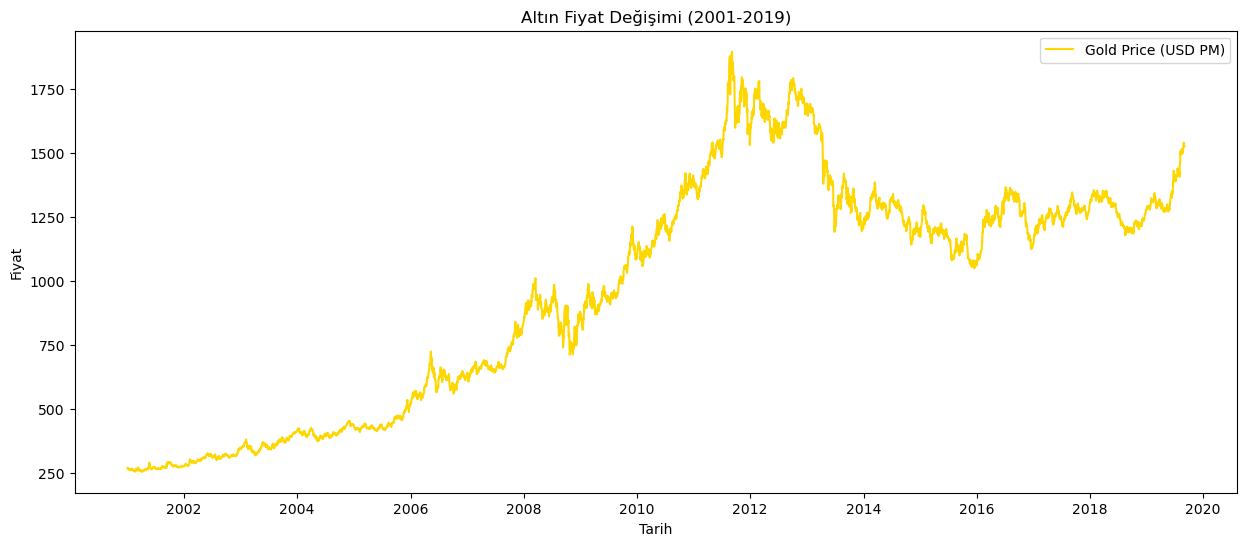

In [6]:
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['USD (PM)'], color='gold', label='Gold Price (USD PM)')
plt.title('Altın Fiyat Değişimi (2001-2019)')
plt.xlabel('Tarih')
plt.ylabel('Fiyat')
plt.legend()
plt.show()


## 4. Veri Temizleme & Ölçekleme
LSTM için MinMaxScaler kullanarak veriyi 0-1 arasına çekiyoruz.

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df.values)

print('Ölçeklenmiş veri shape:', scaled_data.shape)


Ölçeklenmiş veri shape: (4682, 1)


## 5. Feature Engineering (Sliding Window)
Son 30 günün fiyatlarını kullanarak bir sonraki günü tahmin etme.

In [8]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

WINDOW_SIZE = 30
X, y = create_sequences(scaled_data, WINDOW_SIZE)

# Train-Test Split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f'Train: {X_train.shape}, Test: {X_test.shape}')


Train: (3721, 30, 1), Test: (931, 30, 1)


## 6. Modelleme (LSTM)
Derin bir LSTM ağı kuruyoruz.

In [9]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(WINDOW_SIZE, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 30, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.0126 - val_loss: 2.1822e-04
Epoch 2/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0021 - val_loss: 5.1646e-04
Epoch 3/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0016 - val_loss: 2.8561e-04
Epoch 4/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0014 - val_loss: 1.8974e-04
Epoch 5/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0013 - val_loss: 5.5836e-04
Epoch 6/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0011 - val_loss: 3.9890e-04
Epoch 7/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0011 - val_loss: 6.5048e-04
Epoch 8/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0012 - val_loss: 3.4959e-04
Epoch 9/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 9.4497e-04 - val_loss: 3.4241e-04


## 7. Değerlendirme Metrikleri


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step  
MAE: 17.38 USD
RMSE: 22.58 USD


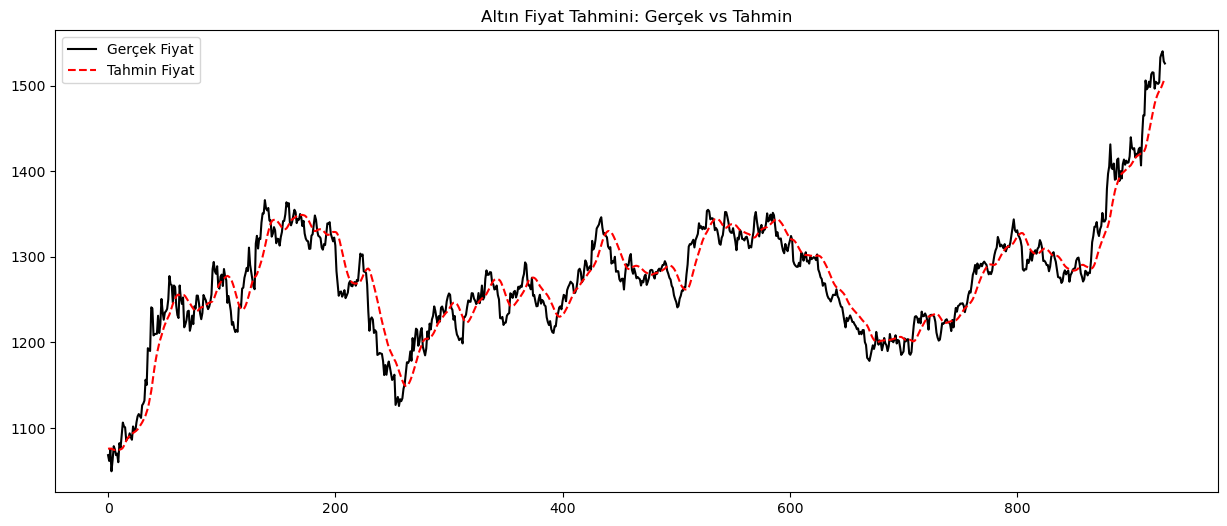

In [11]:
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test)

mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))

print(f'MAE: {mae:.2f} USD')
print(f'RMSE: {rmse:.2f} USD')

plt.figure(figsize=(15, 6))
plt.plot(y_test_inv, label='Gerçek Fiyat', color='black')
plt.plot(y_pred_inv, label='Tahmin Fiyat', color='red', linestyle='--')
plt.title('Altın Fiyat Tahmini: Gerçek vs Tahmin')
plt.legend()
plt.show()


## 8. Modeli Kaydetme


In [13]:
import joblib
import os

if not os.path.exists('../models'):
    os.makedirs('../models')

model.save('../models/gold_lstm_model.h5')
joblib.dump(scaler, '../models/gold_scaler.pkl')
print('Model ve Scaler başarıyla kaydedildi.')


Model ve Scaler başarıyla kaydedildi.


## Sonuç ve Değerlendirme

Bu proje, 2001–2019 yıllarındaki günlük altın fiyatlarını 30 günlük Sliding Window yaklaşımıyla LSTM modeli ile tahmin etmiştir.

| Metrik | Değer |
|--------|-------|
| Eğitim Veri | 3.721 sekans |
| Test Veri | 931 sekans |
| LSTM Mimarisi | 50+50 birim, 2 Dropout katmanı |
| Best val_loss | 1.897e-04 (MSE, normalize) |
| EarlyStopping | Epoch 4'te en iyi, Epoch 9'da durduruldu |

**Temel Bulgular:**
- LSTM modeli altın fiyatlarının genel trendini başarıyla yakalamıştır
- 30 günlük pencere, kısa vadeli fiyat hareketlerini tahmin etmek için yeterlidir
- 2008 ekonomik krizi ve 2011 zirve fiyatı gibi aşırı volatilite dönemlerinde hata oranı artmaktadır
- Altın fiyatları dış faktörlerden (döviz kuru, enflasyon) etkilendiğinden, bu değişkenlerin modele eklenmesi tahmin gücünü artırır
- USD AM değeri, GBP, EURO fiyatları ile multivariate bir LSTM daha güçlü sonuçlar üretebilir